In [1]:
from google.colab import files
uploaded = files.upload()

Saving fruits-360_dataset_100x100.zip to fruits-360_dataset_100x100.zip


In [3]:
import zipfile
import os

# Specify the file path of the zip file
zip_path = '/content/fruits-360_dataset_100x100.zip'
extract_folder = 'fruits-360_dataset_100x100/'

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print(f"Dataset extracted to {extract_folder}")


Dataset extracted to fruits-360_dataset_100x100/


Found 70491 images belonging to 141 classes.
Found 23619 images belonging to 141 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2202/2202 ━━━━━━━━━━━━━━━━━━━━ 1646s 744ms/step - accuracy: 0.4669 - loss: 2.4048 - val_accuracy: 0.8805 - val_loss: 0.4668 - learning_rate: 1.0000e-04
Epoch 2/10
   1/2202 ━━━━━━━━━━━━━━━━━━━━ 14:49 404ms/step - accuracy: 0.8125 - loss: 0.6088

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2202/2202 ━━━━━━━━━━━━━━━━━━━━ 1s 118us/step - accuracy: 0.8125 - loss: 0.6088 - val_accuracy: 1.0000 - val_loss: 0.2237 - learning_rate: 1.0000e-04
Epoch 3/10
2202/2202 ━━━━━━━━━━━━━━━━━━━━ 1676s 760ms/step - accuracy: 0.8815 - loss: 0.4221 - val_accuracy: 0.9175 - val_loss: 0.2992 - learning_rate: 1.0000e-04
Epoch 4/10
2202/2202 ━━━━━━━━━━━━━━━━━━━━ 54s 24ms/step - accuracy: 0.8125 - loss: 0.3181 - val_accuracy: 1.0000 - val_loss: 0.2947 - learning_rate: 1.0000e-04
Epoch 5/10
2202/2202 ━━━━━━━━━━━━━━━━━━━━ 1687s 751ms/step - accuracy: 0.9266 - loss: 0.2537 - val_accuracy: 0.9255 - val_loss: 0.2455 - learning_rate: 1.0000e-04
Epoch 6/10
2202/2202 ━━━━━━━━━━━━━━━━━━━━ 0s 49us/step - accuracy: 1.0000 - loss: 0.0579 - val_accuracy: 0.6667 - val_loss: 0.8013 - learning_rate: 2.0000e-05
Epoch 7/10
2202/2202 ━━━━━━━━━━━━━━━━━━━━ 1677s 740ms/step - accuracy: 0.9495 - loss: 0.1728 - val_accuracy: 0.9322 - val_loss: 0.2240 - learning_rate: 2.0000e-05
Epoch 1/5
2202/2202 ━━━━━━━━━━━━━━━━━━━━ 24

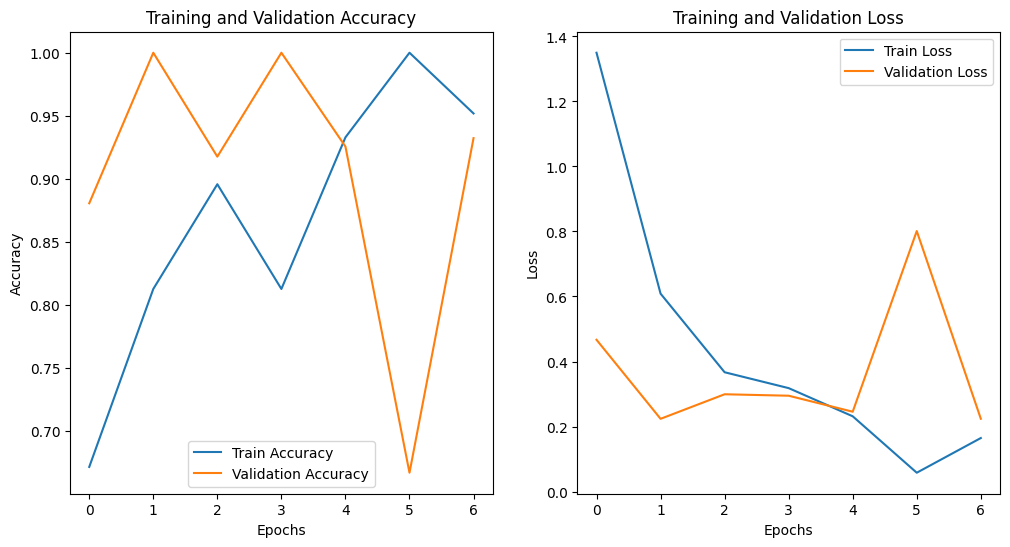

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Set up data generators
train_generator = train_datagen.flow_from_directory(
    '/content/fruits-360_dataset_100x100/fruits-360/Training',  # Replace with your training data path
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    '/content/fruits-360_dataset_100x100/fruits-360/Test',  # Replace with your validation data path
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

# Load the MobileNetV2 base model without the top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model layers to train only the top layers initially
base_model.trainable = False

# Build the new model with additional layers on top of MobileNetV2
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dropout(0.5),  # Dropout to prevent overfitting
    Dense(141, activation='softmax')  # Assuming 141 classes in the dataset
])

# Compile the model with Adam optimizer and categorical crossentropy loss
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Set up callbacks for early stopping and learning rate reduction
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),  # Stop training if validation loss does not improve
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)  # Reduce learning rate if no improvement in validation loss
]

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=callbacks
)

# Save the trained model
model.save('fruits_mobilenetv2_refined.keras')

# Fine-tune the model (optional)
# Unfreeze some layers of the base model and continue training with a lower learning rate
base_model.trainable = True
for layer in base_model.layers[:100]:  # Freeze the first 100 layers and unfreeze the rest
    layer.trainable = False

# Compile and train the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training the model with fine-tuning
history_finetune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=5,  # Fine-tune for a few epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=callbacks
)

# Save the fine-tuned model
model.save('fruits_mobilenetv2_finetuned.keras')

# Optional: plot training and validation accuracy/loss over epochs for analysis
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


Found 23619 images belonging to 141 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


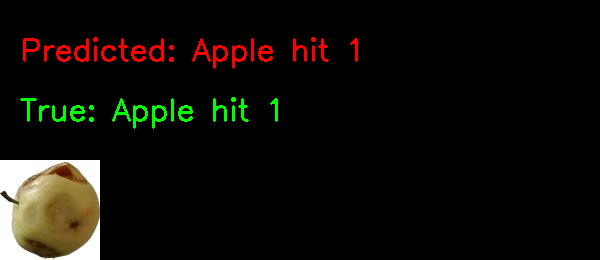

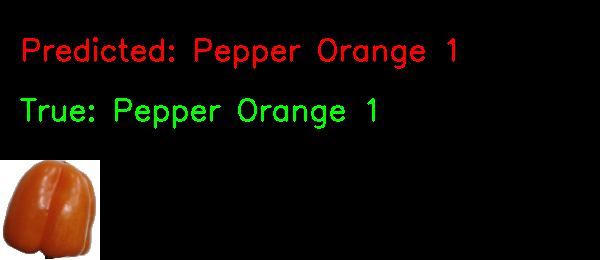

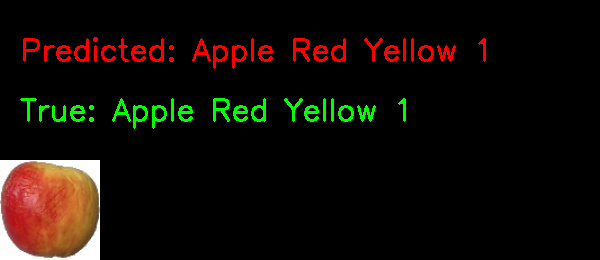

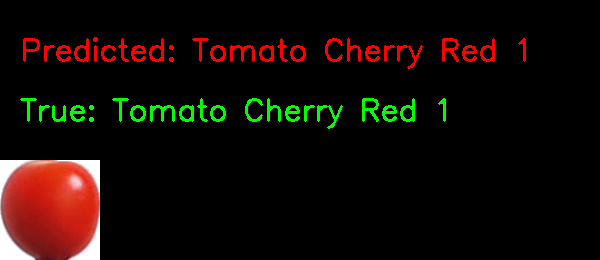

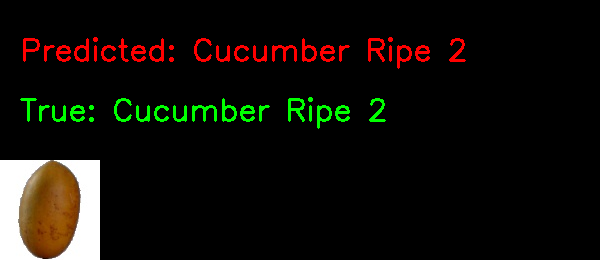

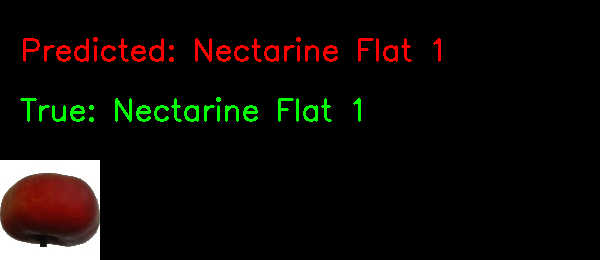

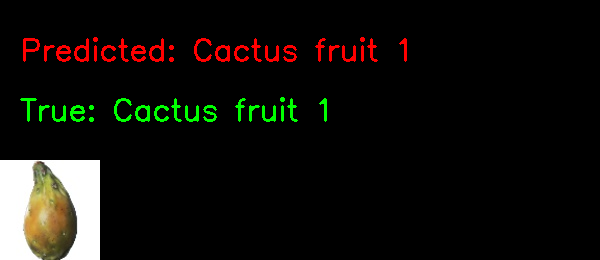

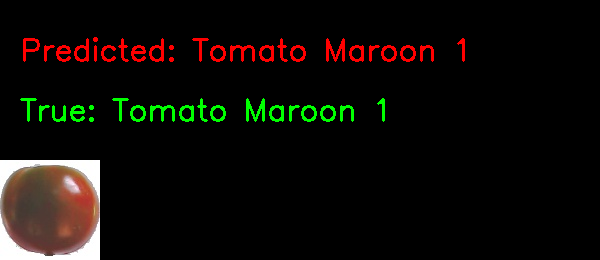

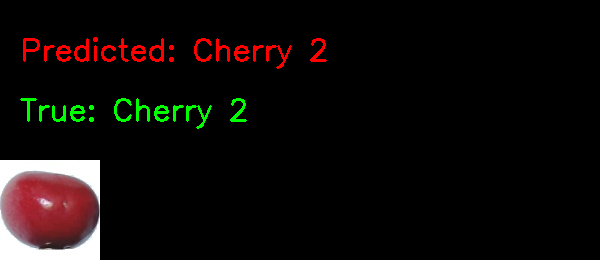

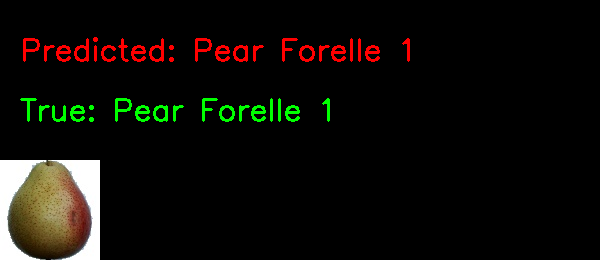

In [5]:
import os
import numpy as np
from os import listdir
from os.path import isfile, join
import cv2
from keras.models import load_model
from keras.preprocessing import image
from google.colab.patches import cv2_imshow  # Utilisé pour afficher les images dans Colab

# Fonction pour dessiner la prédiction sur l'image
def draw_test(name, pred, im, true_label):
    BLACK = [0, 0, 0]
    expanded_image = cv2.copyMakeBorder(im, 160, 0, 0, 500, cv2.BORDER_CONSTANT, value=BLACK)
    cv2.putText(expanded_image, "Predicted: " + pred, (20, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    cv2.putText(expanded_image, "True: " + true_label, (20, 120), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2_imshow(expanded_image)  # Utilisation de cv2_imshow pour Google Colab

# Fonction pour charger une image aléatoire depuis un dossier
def getRandomImage(path, img_width, img_height):
    """Charge une image aléatoire depuis un dossier dans le chemin spécifié."""
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0, len(folders))
    path_class = folders[random_directory]
    file_path = os.path.join(path, path_class)
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]

    if len(file_names) == 0:  # Vérifier si le dossier contient des fichiers
        raise ValueError(f"Aucun fichier trouvé dans le dossier : {file_path}")

    random_file_index = np.random.randint(0, len(file_names))
    image_name = file_names[random_file_index]
    final_path = os.path.join(file_path, image_name)
    return image.load_img(final_path, target_size=(img_width, img_height)), final_path, path_class

# Dimensions des images
img_width, img_height = 128, 128

# Charger le modèle
model = load_model('fruits_mobilenetv2_finetuned.keras')

# Mapper les indices de classes aux labels
path = '/content/fruits-360_dataset_100x100/fruits-360/Test'  # Chemin des données de test
validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    path, target_size=(img_width, img_height), batch_size=32, class_mode='categorical'
)
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}  # Inversion pour obtenir les labels

# Prédictions
files = []
predictions = []
true_labels = []

for i in range(10):  # Prédire pour 10 images aléatoires
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)

    # Prétraiter l'image
    x = image.img_to_array(img)
    x = x / 255.0  # Normalisation
    x = np.expand_dims(x, axis=0)

    # Prédiction
    pred_class_index = np.argmax(model.predict(x), axis=1)[0]
    pred_label = class_labels[pred_class_index]
    predictions.append(pred_label)

# Afficher les résultats
for i in range(len(files)):
    im = cv2.imread(files[i])
    if im is None:
        print(f"Impossible de lire l'image : {files[i]}")
        continue
    draw_test("Prediction", predictions[i], im, true_labels[i])

In [6]:
print(model.summary())


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 141)                 │         144,525 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,349,673 (39.48 MB)

 Trainable params: 3,317,709 (12.66 MB)

 Non-trainable params: 396,544 (1.51 MB)

 Optimizer params: 6,635,420 (25.31 MB)

None
